In [1]:
import cv2
import numpy as np
import os
from scipy.linalg import null_space
from scipy.optimize import fmin_cg
import matplotlib.pyplot as plt
import json

In [4]:
'''Images and camera matrices downloaded from https://www.di.ens.fr/pmvs/pmvs-1/index.html'''
#Get current directory
cwd = os.getcwd()
img_files = os.listdir(cwd+"/Images/")
n_im = len(img_files)

In [5]:
#Get projection matrices for all the images
#Calculate the camera centres(optical centres) and the pseudo inverse for each projection matrix
camera_mat_data = np.zeros((3,4,n_im))
camera_cent = np.zeros((4,1,n_im))
pinv_camera_mat = np.zeros((4,3,n_im))
for i in range(n_im):
    with open(cwd+"/Camera_mat/{:04d}".format(i)+".txt",'r') as f:
        f.readline()
        data=f.readlines()
        camera_mat_data[:,:,i] = np.loadtxt(data)
        camera_cent[:,:,i] = null_space(camera_mat_data[:,:,i])
        pinv_camera_mat[:,:,i] = np.linalg.pinv(camera_mat_data[:,:,i])
        f.close()

In [6]:
#Read the images and extract features using SIFT

l_im = []
feat_coord = []
for i in range(n_im):
    im = cv2.imread(cwd+"/Images/{:04d}".format(i)+".jpg")
    # [r,c,ch] = np.shape(im)
    sift = cv2.xfeatures2d.SIFT_create()
    # kp = sift.detect(im,None)
    key,des=sift.detectAndCompute(im,None)
    unique_key = np.unique(cv2.KeyPoint_convert(key),axis=0)
#     unique_key[:,[0,1]]=unique_key[:,[1,0]]
    feat_coord.append(np.hstack((unique_key,np.ones((unique_key.shape[0],1)))))
    l_im.append(im)

In [175]:
#Finding the epipolar lines for each features in every image.
h_pi = np.zeros((n_im,n_im,3,3))
for i in range(n_im):
    for j in range(n_im):
        h_pi[i,j,:,:] = camera_mat_data[:,:,j]@pinv_camera_mat[:,:,i]

epipoles = np.zeros((n_im,n_im,3,1))

#Convert epipoles to cross product matrix to vectorize the further process
e_cross_mat = np.zeros((n_im,n_im,3,3))
for i in range(n_im):
    for j in range(n_im):
        epipoles[i,j,:,:] = camera_mat_data[:,:,i]@camera_cent[:,:,j]
        epipoles[i,j,:,:] /= epipoles[i,j,2]
        e_cross_mat[i,j,:,:] = np.array([[0, -epipoles[i,j,2], epipoles[i,j,1]],
                                       [epipoles[i,j,2], 0, -epipoles[i,j,0]],
                                       [-epipoles[i,j,1], epipoles[i,j,0], 0]])

epi_lines = {}
for i in range(n_im):
    for j in range(n_im):
        if i!=j :
            epi_lines[(i,j)] = e_cross_mat[j,i,:,:]@h_pi[i,j,:,:]@feat_coord[i].T

In [176]:
#Find all the features in other images that are within 2 piel distance from the epipolar line
feat_corres_raw = {}
for i in range(n_im):
    for j in range(n_im):
        if i!=j:
            feat_corres_raw[(i,j)] = {}
            
            pxl_data = feat_coord[j]
            line_data = epi_lines[(i,j)]
            denom = np.sqrt(line_data[0]**2 + line_data[1]**2)
            
            dist_data = abs(pxl_data@line_data)/denom
            
            for f in range(feat_coord[i].shape[0]):
                feat_corres_raw[(i,j)][f] = np.where(dist_data[:,f] <=2)[0]


In [50]:
#Divide the image into 2x2 cells
#NOTE: These cells have not been used in the main implementation due to lack of time
c_ixy={} #Cell to feature pt correspondence
rev_c_ixy={} #Feature pt to cell correspondence
for i in range(n_im):
    c_ixy[i]={}
    rev_c_ixy[i]={}
    floored_feat = np.floor(feat_coord[i])[:,:2]
    for f_ind in range(len(floored_feat)):
        [x,y] = floored_feat[f_ind,:] - (floored_feat[f_ind,:]%2)
        rev_c_ixy[i][f_ind]=[x,y]
        try:
            c_ixy[i][(x,y)].append(f_ind)
        except:
            c_ixy[i][(x,y)]=[f_ind]

In [205]:
#Initialiation patch parameters(centre, normal and Reference image)
def initialize_patch(camera_mat1,camera_mat2,f_i,f_n,O_i):
#     f_i = np.array([f_i]*np.shape(f_n)[0])
#     print(f_i.shape)
    c_p = cv2.triangulatePoints(camera_mat1,camera_mat2,f_i.T,f_n.T)
    c_p /= c_p[-1,:]
    O_i /= O_i[-1]
    n_p_vec = O_i-c_p
    n_p = n_p_vec/np.linalg.norm(n_p_vec,axis=0)
    return c_p, n_p

#Create the 5x5 grid patch
def make_patch_grid(c_p, n_p, x_h, grid_mu = 5):
    c_p /= c_p[3,:]
    
    y_h = np.zeros((4,1))
    y_h[:3]=np.cross(n_p[:3].T,x_h[:3].T).T
    
    grid_range = int(grid_mu/2)
    patch_mat = np.zeros((grid_mu,grid_mu,4,1))
    for i in range(-grid_range, grid_range+1):
        for j in range(-grid_range, grid_range+1):
            patch_mat[i+grid_range,j+grid_range,:,:] = c_p+i*x_h+j*y_h
    return patch_mat

#Project the points on the grid onto the image to sample pixel values
def grid_proj(patch_mat, camera_mat, mu=5):
    grid_proj_pxl = np.zeros((mu,mu,2,1))
    for i in range(mu):
        for j in range(mu):
            temp_pxl = camera_mat@patch_mat[i,j,:,:]
            grid_proj_pxl[i,j,:,:] = temp_pxl[:2,:]/temp_pxl[2,0]
    return grid_proj_pxl

#Bilineaer interpolation code for sampling pixel values from the image
def bilinear_inter(pxl_pt,im):
    [row,col,ch]=im.shape
    pxl_pt = np.squeeze(pxl_pt)
    [x1,y1] = np.array(np.floor(pxl_pt),dtype=np.int32)
    [x2,y2] = np.array(np.ceil(pxl_pt),dtype=np.int32)

    if 0<pxl_pt[0]<=row-1 and 0<pxl_pt[1]<=col-1:
        X = np.array([[x2-pxl_pt[0]],[pxl_pt[0]-x1]])
        Y = np.array([[y2-pxl_pt[1]],[pxl_pt[1]-y1]])
        pxl_val = np.array([(X.T)@im[x1:x2+1,y1:y2+1,i]@Y for i in range(np.shape(im)[-1])])
#         try:
#             pxl_val = np.array([(X.T)@im[x1:x2+1,y1:y2+1,i]@Y for i in range(np.shape(im)[-1])])
#         except:
#             print(pxl_pt,[x1,x2],[y1,y2],im.shape,im[x1:x2+1,y1:y2+1,:])
    else:
        if not 0<pxl_pt[0]<=row-1:
            if pxl_pt[0]<0:
                x1=0
                x2=0
            else:
                x1=row-1
                x2=row-1
        if not 0<pxl_pt[1]<=col-1:
            if pxl_pt[1]<0:
                y1=0
                y2=0
            else:
                y1=col-1
                y2=col-1
        pxl_val=((im[x1,y1,:]+im[x2,y2,:])/2)
    
    return pxl_val.squeeze()

#Pairwise discrepancy function
def calc_q(patch_mat, im, camera_mat):
    grid_proj_pxl = grid_proj(patch_mat, camera_mat, mu=5)
    mu = len(patch_mat)
    samp_pxl_grid = np.zeros((mu,mu,np.shape(im)[-1]),dtype=np.float32)
    for i in range(mu):
        for j in range(mu):
            samp_pxl_grid[i,j,:] = bilinear_inter(grid_proj_pxl[i,j,:],im)
    
    return samp_pxl_grid

#Photometric Discrepancy Function
def calcPhotoDiscrepancy(c_p, n_p, x_h, ref_ind, l_im, vis_im_ind, camera_mat_data):
	im_ref = l_im[ref_ind]
	camera_mat_ref = camera_mat_data[:,:,ref_ind]
	patch_mat = make_patch_grid(c_p, n_p, x_h, grid_mu=5)
	q_ref = calc_q(patch_mat, im_ref, camera_mat_ref)
	pairwise_pdf = []
    
	for im_ind in vis_im_ind:
		q = calc_q(patch_mat, l_im[im_ind], camera_mat_data[:,:,im_ind])
		pairwise_pdf.append(1-np.squeeze(cv2.matchTemplate(q_ref,q,eval('cv2.TM_CCORR_NORMED'))))
    
	return (np.sum(pairwise_pdf)/(len(vis_im_ind)-1))

In [206]:
#Sort the corresponding features w.r.t to their respective epipoles
def get_sorted_feat_corres(ref_ind, f_ind, feat_corres_raw, feat_coord, im_epipole):
    F = []
    dist = []
    for j in range(n_im):
        curr_epipole = im_epipole[j,:,:].T
        if j!=ref_ind:
            try:
                temp_f = feat_coord[j][feat_corres_raw[(ref_ind, j)][f_ind],:]
                F = np.concatenate((F,temp_f),axis=0)
                temp_dist = np.linalg.norm(temp_f-curr_epipole,axis=1)
                dist = np.concatenate((dist,temp_dist))
                im_ind = np.concatenate((im_ind, j*np.ones(np.shape(temp_dist),dtype=np.int32)))
            except:
                F = feat_coord[j][feat_corres_raw[(ref_ind, j)][f_ind],:]
                dist = np.linalg.norm(F-curr_epipole,axis=1)
                im_ind = j*np.ones(np.shape(dist),dtype=np.int32)

    sort_ind = np.argsort(dist)
    return F[sort_ind,:],im_ind[sort_ind]#,temp_dist,dist

In [207]:
#Get the set of visible images
def check_visible_images(c_p,n_p,O):
    tau = np.pi/3
    O /= O[-1]
    n_vec = O-c_p
    n = n_vec/np.linalg.norm(n_vec,axis=0)
    angle = (n_p.T@n).item()
    return angle>np.cos(tau)

#Convert unit vector to euler angles
def get_euler_angle(n):
    x,y,z,_ = n
    yaw = np.arctan2(y,x)
    pitch = np.arccos(z)
    return yaw,pitch

#Function to be used in conjugate gradient method for optimizing centre and normal of the patch
def conjugate_gradient_func(val, *args):
    [depth,yaw,pitch] = val
    O_i, x_h, i, l_im, V_p, camera_mat_data = args
    x=np.sin(pitch)*np.cos(yaw)
    y=np.sin(pitch)*np.sin(yaw)
    z=np.cos(pitch)
    n_p = np.array([[x,y,z,0]],dtype=np.float32).T
    c_p = O_i - n_p*depth
    
    g_p = calcPhotoDiscrepancy(c_p, n_p, x_h, i, l_im, V_p, camera_mat_data)
    return g_p

In [247]:
Patches={'c_p':[],'n_p':[],'Ref_im_ind':[],'Ref_im_feat':[],'Corres_im_ind':[],'Corres_im_feat':[],'Visible_Images':[]}
for i in range(n_im):
    print("Image ",i+1)
    R_p = l_im[i]
    O_i = camera_cent[:,:,i]
    for f_ind in range(len(feat_coord[i])):
        print("Feature ",f_ind+1)
        f_i = feat_coord[i][f_ind,:2]
        F,im_ind = get_sorted_feat_corres(i, f_ind, feat_corres_raw, feat_coord, epipoles[:,i,:])
        for f_n_ind in range(len(im_ind)):
            V_p = []
            V_pn= []
            f_n = F[f_n_ind,:2]
            c_p,n_p = initialize_patch(camera_mat_data[:,:,i],camera_mat_data[:,:,im_ind[f_n_ind]],f_i[np.newaxis,:],f_n[np.newaxis,:],O_i)
            for ii in range(n_im):
                if check_visible_images(c_p,n_p,camera_cent[:,:,ii]):
                    V_p.append(ii)
                    g_p=calcPhotoDiscrepancy(c_p, n_p, x_h, i, l_im, [i,ii], camera_mat_data)
                    #Getting V*(p) for V(p)
                    if g_p<0.6:
                        V_pn.append(ii)
            
            x_dir = pinv_camera_mat[:,:,i]@np.array([[1],[0],[0]])
            x_h = x_dir/np.linalg.norm(x_dir)
            yaw,pitch = get_euler_angle(n_p)
            depth=np.linalg.norm(O_i-c_p,axis=0)
            val0 = [depth,yaw,pitch] #The parameters to be optimized
            args = (O_i, x_h, i, l_im, V_pn, camera_mat_data)
            #The function that finds the optimized values using gradient descent method
            [depth,yaw,pitch]=fmin_cg(conjugate_gradient_func, val0, args=args)
            x=np.sin(pitch)*np.cos(yaw)
            y=np.sin(pitch)*np.sin(yaw)
            z=np.cos(pitch)
            n_p = np.array([[x,y,z,0]],dtype=np.float32).T
            c_p = O_i - n_p*depth
            V_p = []
            V_pn= []
            for ii in range(n_im):
                if check_visible_images(c_p,n_p,camera_cent[:,:,ii]):
                    V_p.append(ii)
                    g_p=calcPhotoDiscrepancy(c_p, n_p, x_h, i, l_im, [i,ii], camera_mat_data)
                    if g_p<0.3:
                        V_pn.append([ii,g_p])
            if len(V_pn)<8:
                continue
            
            Patches['c_p'].append(c_p)
            Patches['n_p'].append(n_p)
            Patches['Ref_im_ind'].append(i)
            Patches['Ref_im_feat'].append(f_i)
            Patches['Corres_im_ind'].append(im_ind[f_n_ind])
            Patches['Corres_im_feat'].append(f_n)
            Patches['Visible_Images'].append(V_p)
            break

Image  1
Feature  1
Optimization terminated successfully.
         Current function value: 0.003666
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  2
Optimization terminated successfully.
         Current function value: 0.000244
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  3
Optimization terminated successfully.
         Current function value: 0.000321
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  4
Optimization terminated successfully.
         Current function value: 0.008772
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  5
Optimization terminated successfully.
         Current function value: 0.000353
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  6
Optimization terminated successfully.
         Current function value: 0.011

Feature  39
Optimization terminated successfully.
         Current function value: 0.000421
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  40
Optimization terminated successfully.
         Current function value: 0.000379
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  41
Optimization terminated successfully.
         Current function value: 0.010206
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  42
Optimization terminated successfully.
         Current function value: 0.014177
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  43
Optimization terminated successfully.
         Current function value: 0.057837
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  44
Optimization terminated successfully.
         Current function value: 0.001190
 

Optimization terminated successfully.
         Current function value: 0.000624
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  80
Optimization terminated successfully.
         Current function value: 0.028776
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  81
Optimization terminated successfully.
         Current function value: 0.001531
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.001173
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  82
Optimization terminated successfully.
         Current function value: 0.001200
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Feature  83
Optimization terminated successfully.
         Current function value: 0.042665
         Iterations: 0


Optimization terminated successfully.
         Current function value: 0.001544
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.014037
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  121
Optimization terminated successfully.
         Current function value: 0.004945
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  122
Optimization terminated successfully.
         Current function value: 0.000276
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  123
Optimization terminated successfully.
         Current function value: 0.000267
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  124
Optimization terminated successfully.
         Current function value: 0.000775
         Iterations:

Feature  162
Optimization terminated successfully.
         Current function value: 0.000354
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  163
Optimization terminated successfully.
         Current function value: 0.001162
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  164
Optimization terminated successfully.
         Current function value: 0.000093
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  165
Optimization terminated successfully.
         Current function value: 0.003342
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  166
Optimization terminated successfully.
         Current function value: 0.000910
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  167
Optimization terminated successfully.
         Current function value: 0.

Feature  205
Optimization terminated successfully.
         Current function value: 0.000366
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  206
Optimization terminated successfully.
         Current function value: 0.006342
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  207
Optimization terminated successfully.
         Current function value: 0.002894
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  208
Optimization terminated successfully.
         Current function value: 0.001122
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  209
Optimization terminated successfully.
         Current function value: 0.007263
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  210
Optimization terminated successfully.
         Current function value: 0.02

Feature  247
Optimization terminated successfully.
         Current function value: 0.002676
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.021461
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  248
Optimization terminated successfully.
         Current function value: 0.001540
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  249
Optimization terminated successfully.
         Current function value: 0.008203
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  250
Optimization terminated successfully.
         Current function value: 0.000317
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  251
Optimization terminated successfully.
         Current function value: 0.000153
       

Feature  290
Optimization terminated successfully.
         Current function value: 0.000263
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  291
Optimization terminated successfully.
         Current function value: 0.008039
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  292
Optimization terminated successfully.
         Current function value: 0.007218
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  293
Optimization terminated successfully.
         Current function value: 0.000083
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  294
Optimization terminated successfully.
         Current function value: 0.000348
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  295
Optimization terminated successfully.
         Current function value: 0.00

Feature  335
Optimization terminated successfully.
         Current function value: 0.011950
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  336
Optimization terminated successfully.
         Current function value: 0.004267
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  337
Optimization terminated successfully.
         Current function value: 0.020921
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  338
Optimization terminated successfully.
         Current function value: 0.000350
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  339
Optimization terminated successfully.
         Current function value: 0.001236
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  340
Optimization terminated successfully.
         Current function value: 0.00

Feature  380
Optimization terminated successfully.
         Current function value: 0.001062
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  381
Optimization terminated successfully.
         Current function value: 0.002453
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  382
Optimization terminated successfully.
         Current function value: 0.027111
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  383
Optimization terminated successfully.
         Current function value: 0.000391
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  384
Optimization terminated successfully.
         Current function value: 0.002321
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  385
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.031388
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  425
Optimization terminated successfully.
         Current function value: 0.000337
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  426
Optimization terminated successfully.
         Current function value: 0.000344
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  427
Optimization terminated successfully.
         Current function value: 0.000234
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  428
Optimization terminated successfully.
         Current function value: 0.019675
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  429
Optimization terminated successfully.
         Current function value: 0.000230
        

Feature  466
Optimization terminated successfully.
         Current function value: 0.001455
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  467
Optimization terminated successfully.
         Current function value: 0.000559
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  468
Optimization terminated successfully.
         Current function value: 0.000280
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  469
Optimization terminated successfully.
         Current function value: 0.022504
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  470
Optimization terminated successfully.
         Current function value: 0.005538
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  471
Optimization terminated successfully.
         Current function value: 0.02

Feature  510
Optimization terminated successfully.
         Current function value: 0.000273
         Iterations: 1
         Function evaluations: 30
         Gradient evaluations: 6
Feature  511
Optimization terminated successfully.
         Current function value: 0.001694
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.001343
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.001682
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.001341
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.001667
         Iterations: 1
         Function eva

Feature  549
Optimization terminated successfully.
         Current function value: 0.000290
         Iterations: 1
         Function evaluations: 30
         Gradient evaluations: 6
Feature  550
Optimization terminated successfully.
         Current function value: 0.003465
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  551
Optimization terminated successfully.
         Current function value: 0.003056
         Iterations: 1
         Function evaluations: 20
         Gradient evaluations: 4
Feature  552
Optimization terminated successfully.
         Current function value: 0.001501
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  553
Optimization terminated successfully.
         Current function value: 0.000160
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  554
Optimization terminated successfully.
         Current function value: 0

Feature  593
Optimization terminated successfully.
         Current function value: 0.001199
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  594
Optimization terminated successfully.
         Current function value: 0.000406
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  595
Optimization terminated successfully.
         Current function value: 0.000323
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  596
Optimization terminated successfully.
         Current function value: 0.038645
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  597
Optimization terminated successfully.
         Current function value: 0.000161
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  598
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.000184
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  637
Optimization terminated successfully.
         Current function value: 0.000460
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  638
Optimization terminated successfully.
         Current function value: 0.001276
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.044045
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  639
Optimization terminated successfully.
         Current function value: 0.004320
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  640
Optimization terminated successfully.
         Current function value: 0.001313
         Iterations

Feature  680
Optimization terminated successfully.
         Current function value: 0.000127
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  681
Optimization terminated successfully.
         Current function value: 0.001447
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  682
Optimization terminated successfully.
         Current function value: 0.001211
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  683
Optimization terminated successfully.
         Current function value: 0.000925
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  684
Optimization terminated successfully.
         Current function value: 0.000548
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  685
Optimization terminated successfully.
         Current function value: 0

Feature  723
Optimization terminated successfully.
         Current function value: 0.002116
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  724
Optimization terminated successfully.
         Current function value: 0.000272
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  725
Optimization terminated successfully.
         Current function value: 0.019975
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  726
Optimization terminated successfully.
         Current function value: 0.016858
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  727
Optimization terminated successfully.
         Current function value: 0.000193
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  728
Optimization terminated successfully.
         Current function value: 0.00

Optimization terminated successfully.
         Current function value: 0.000611
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  765
Optimization terminated successfully.
         Current function value: 0.022381
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  766
Optimization terminated successfully.
         Current function value: 0.000474
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  767
Optimization terminated successfully.
         Current function value: 0.000685
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  768
Optimization terminated successfully.
         Current function value: 0.000307
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  769
Optimization terminated successfully.
         Current function value: 0.000298
       

Optimization terminated successfully.
         Current function value: 0.001551
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  805
Optimization terminated successfully.
         Current function value: 0.002280
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  806
Optimization terminated successfully.
         Current function value: 0.000497
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  807
Optimization terminated successfully.
         Current function value: 0.027294
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  808
Optimization terminated successfully.
         Current function value: 0.002246
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  809
Optimization terminated successfully.
         Current function value: 0.034812
      

Optimization terminated successfully.
         Current function value: 0.000354
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  848
Optimization terminated successfully.
         Current function value: 0.000456
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  849
Optimization terminated successfully.
         Current function value: 0.018067
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  850
Optimization terminated successfully.
         Current function value: 0.053024
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  851
Optimization terminated successfully.
         Current function value: 0.002771
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.000463
         Iterations: 

Optimization terminated successfully.
         Current function value: 0.000394
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  887
Optimization terminated successfully.
         Current function value: 0.000421
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  888
Optimization terminated successfully.
         Current function value: 0.033636
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  889
Optimization terminated successfully.
         Current function value: 0.001851
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  890
Optimization terminated successfully.
         Current function value: 0.020559
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  891
Optimization terminated successfully.
         Current function value: 0.001851
       

Feature  926
Optimization terminated successfully.
         Current function value: 0.022851
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  927
Optimization terminated successfully.
         Current function value: 0.003137
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.042124
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  928
Optimization terminated successfully.
         Current function value: 0.061759
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  929
Optimization terminated successfully.
         Current function value: 0.056077
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  930
Optimization terminated successfully.
         Current function value: 0.056291
         

Optimization terminated successfully.
         Current function value: 0.003724
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  966
Optimization terminated successfully.
         Current function value: 0.001555
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  967
Optimization terminated successfully.
         Current function value: 0.001469
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  968
Optimization terminated successfully.
         Current function value: 0.024935
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  969
Optimization terminated successfully.
         Current function value: 0.003454
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.000228
         Iterations

Optimization terminated successfully.
         Current function value: 0.003547
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1005
Optimization terminated successfully.
         Current function value: 0.024652
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1006
Optimization terminated successfully.
         Current function value: 0.044667
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1007
Optimization terminated successfully.
         Current function value: 0.034978
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1008
Optimization terminated successfully.
         Current function value: 0.001190
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1009
Optimization terminated successfully.
         Current function value: 0.028791
   

Feature  1043
Optimization terminated successfully.
         Current function value: 0.000107
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1044
Optimization terminated successfully.
         Current function value: 0.000161
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1045
Optimization terminated successfully.
         Current function value: 0.000397
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1046
Optimization terminated successfully.
         Current function value: 0.024242
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1047
Optimization terminated successfully.
         Current function value: 0.000979
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1048
Optimization terminated successfully.
         Current function valu

Feature  1082
Optimization terminated successfully.
         Current function value: 0.034585
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1083
Optimization terminated successfully.
         Current function value: 0.027349
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1084
Optimization terminated successfully.
         Current function value: 0.000167
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1085
Optimization terminated successfully.
         Current function value: 0.051280
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1086
Optimization terminated successfully.
         Current function value: 0.000456
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1087
Optimization terminated successfully.
         Current function value

Optimization terminated successfully.
         Current function value: 0.000422
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1122
Optimization terminated successfully.
         Current function value: 0.000124
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1123
Optimization terminated successfully.
         Current function value: 0.000451
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1124
Optimization terminated successfully.
         Current function value: 0.003796
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1125
Optimization terminated successfully.
         Current function value: 0.004086
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.001418
         Itera

Feature  1157
Optimization terminated successfully.
         Current function value: 0.081303
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1158
Optimization terminated successfully.
         Current function value: 0.004195
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.000570
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1159
Optimization terminated successfully.
         Current function value: 0.000844
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1160
Optimization terminated successfully.
         Current function value: 0.004201
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1161
Optimization terminated successfully.
         Current function value: 0.037525
 

Optimization terminated successfully.
         Current function value: 0.033471
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1199
Optimization terminated successfully.
         Current function value: 0.000085
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1200
Optimization terminated successfully.
         Current function value: 0.000228
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.004750
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.004511
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.000381
         Iterations: 1
         Function ev

Feature  1235
Optimization terminated successfully.
         Current function value: 0.000206
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1236
Optimization terminated successfully.
         Current function value: 0.055861
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1237
Optimization terminated successfully.
         Current function value: 0.043268
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1238
Optimization terminated successfully.
         Current function value: 0.050146
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1239
Optimization terminated successfully.
         Current function value: 0.000883
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1240
Optimization terminated successfully.
         Current function value

Optimization terminated successfully.
         Current function value: 0.026408
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1274
Optimization terminated successfully.
         Current function value: 0.041053
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1275
Optimization terminated successfully.
         Current function value: 0.000821
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1276
Optimization terminated successfully.
         Current function value: 0.001586
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1277
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1278
Optimization terminated successfully.
         Current function value: 0.000776
   

Optimization terminated successfully.
         Current function value: 0.000593
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1319
Optimization terminated successfully.
         Current function value: 0.031145
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1320
Optimization terminated successfully.
         Current function value: 0.000985
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1321
Optimization terminated successfully.
         Current function value: 0.000226
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1322
Optimization terminated successfully.
         Current function value: 0.038235
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1323
Optimization terminated successfully.
         Current function value: 0.001637
  

Optimization terminated successfully.
         Current function value: 0.030715
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1361
Optimization terminated successfully.
         Current function value: 0.000780
         Iterations: 1
         Function evaluations: 25
         Gradient evaluations: 5
Feature  1362
Optimization terminated successfully.
         Current function value: 0.001455
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1363
Optimization terminated successfully.
         Current function value: 0.000425
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1364
Optimization terminated successfully.
         Current function value: 0.001368
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1365
Optimization terminated successfully.
         Current function value: 0.000758
 

Optimization terminated successfully.
         Current function value: 0.000491
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1396
Optimization terminated successfully.
         Current function value: 0.018661
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1397
Optimization terminated successfully.
         Current function value: 0.004897
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.001368
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1398
Optimization terminated successfully.
         Current function value: 0.000422
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1399
Optimization terminated successfully.
         Current function value: 0.000115
         Iterat

Optimization terminated successfully.
         Current function value: 0.000483
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1437
Optimization terminated successfully.
         Current function value: 0.000425
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1438
Optimization terminated successfully.
         Current function value: 0.005570
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.041732
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1439
Optimization terminated successfully.
         Current function value: 0.027103
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1440
Optimization terminated successfully.
         Current function value: 0.032133
         Iterati

Feature  1476
Optimization terminated successfully.
         Current function value: 0.000511
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1477
Optimization terminated successfully.
         Current function value: 0.041666
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1478
Optimization terminated successfully.
         Current function value: 0.026393
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1479
Optimization terminated successfully.
         Current function value: 0.039853
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1480
Optimization terminated successfully.
         Current function value: 0.000142
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1481
Optimization terminated successfully.
         Current function value

Optimization terminated successfully.
         Current function value: 0.004676
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1518
Optimization terminated successfully.
         Current function value: 0.001769
         Iterations: 2
         Function evaluations: 55
         Gradient evaluations: 11
Feature  1519
Optimization terminated successfully.
         Current function value: 0.000792
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1520
Optimization terminated successfully.
         Current function value: 0.000412
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1521
Optimization terminated successfully.
         Current function value: 0.001805
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Feature  1522
Optimization terminated successfully.
         Current function value: 0.001450


Optimization terminated successfully.
         Current function value: 0.014201
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1562
Optimization terminated successfully.
         Current function value: 0.001113
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1563
Optimization terminated successfully.
         Current function value: 0.031059
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1564
Optimization terminated successfully.
         Current function value: 0.000353
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1565
Optimization terminated successfully.
         Current function value: 0.029777
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1566
Optimization terminated successfully.
         Current function value: 0.023659
   

Optimization terminated successfully.
         Current function value: 0.003013
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.000169
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1595
Optimization terminated successfully.
         Current function value: 0.000475
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1596
Optimization terminated successfully.
         Current function value: 0.001051
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1597
Optimization terminated successfully.
         Current function value: 0.000267
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1598
Optimization terminated successfully.
         Current function value: 0.000786
         Itera

Feature  1634
Optimization terminated successfully.
         Current function value: 0.000264
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1635
Optimization terminated successfully.
         Current function value: 0.000721
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1636
Optimization terminated successfully.
         Current function value: 0.034291
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1637
Optimization terminated successfully.
         Current function value: 0.000677
         Iterations: 1
         Function evaluations: 30
         Gradient evaluations: 6
Feature  1638
Optimization terminated successfully.
         Current function value: 0.014766
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1639
Optimization terminated successfully.
         Current function value

Feature  1674
Optimization terminated successfully.
         Current function value: 0.000799
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1675
Optimization terminated successfully.
         Current function value: 0.001076
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1676
Optimization terminated successfully.
         Current function value: 0.002825
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.042704
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1677
Optimization terminated successfully.
         Current function value: 0.001150
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1678
Optimization terminated successfully.
         Current function value: 0.000461
  

Feature  1715
Optimization terminated successfully.
         Current function value: 0.000380
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1716
Optimization terminated successfully.
         Current function value: 0.002746
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.001154
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1717
Optimization terminated successfully.
         Current function value: 0.002878
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1718
Optimization terminated successfully.
         Current function value: 0.000735
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1719
Optimization terminated successfully.
         Current function value: 0.000299
 

Optimization terminated successfully.
         Current function value: 0.002765
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.038725
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1754
Optimization terminated successfully.
         Current function value: 0.000078
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1755
Optimization terminated successfully.
         Current function value: 0.000339
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1756
Optimization terminated successfully.
         Current function value: 0.000453
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1757
Optimization terminated successfully.
         Current function value: 0.000489
         Iterat

Optimization terminated successfully.
         Current function value: 0.057365
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1794
Optimization terminated successfully.
         Current function value: 0.000104
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1795
Optimization terminated successfully.
         Current function value: 0.000406
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1796
Optimization terminated successfully.
         Current function value: 0.000415
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1797
Optimization terminated successfully.
         Current function value: 0.024428
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1798
Optimization terminated successfully.
         Current function value: 0.000343
  

Optimization terminated successfully.
         Current function value: 0.002761
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.036531
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1831
Optimization terminated successfully.
         Current function value: 0.000510
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Feature  1832
Optimization terminated successfully.
         Current function value: 0.020809
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1833
Optimization terminated successfully.
         Current function value: 0.040360
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1834
Optimization terminated successfully.
         Current function value: 0.001190
         Iteratio

Feature  1870
Optimization terminated successfully.
         Current function value: 0.000218
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1871
Optimization terminated successfully.
         Current function value: 0.000445
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Feature  1872
Optimization terminated successfully.
         Current function value: 0.097849
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1873
Optimization terminated successfully.
         Current function value: 0.035825
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1874
Optimization terminated successfully.
         Current function value: 0.041163
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1875
Optimization terminated successfully.
         Current function value

Optimization terminated successfully.
         Current function value: 0.064428
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1908
Optimization terminated successfully.
         Current function value: 0.045503
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1909
Optimization terminated successfully.
         Current function value: 0.052538
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1910
Optimization terminated successfully.
         Current function value: 0.002544
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.048427
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1911
Optimization terminated successfully.
         Current function value: 0.002604
         Iteration

Optimization terminated successfully.
         Current function value: 0.017331
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1945
Optimization terminated successfully.
         Current function value: 0.032466
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1946
Optimization terminated successfully.
         Current function value: 0.056780
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Feature  1947
Optimization terminated successfully.
         Current function value: 0.002398
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.002398
         Iterations: 1
         Function evaluations: 10
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: 0.072784
         Iterations: 0
        

# Plot verification

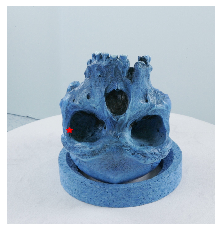

In [287]:
ri=0
fig=plt.figure()
plt.imshow(l_im[ri])
# plt.scatter(feat_coord[0][:,0],feat_coord[0][:,1])
plt.plot(feat_coord[ri][100,0],feat_coord[ri][100,1],'r*')
plt.axis('off')
plt.savefig('Ref_im.png',bbox_inches = 'tight', pad_inches = 0)

In [322]:
i=7
[a,b,c] = epi_lines[(ri,i)].T[100]
x=range(950)
y = -(a*x+c)/b

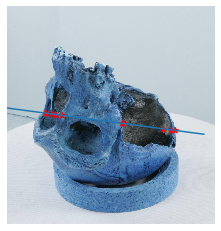

In [324]:
plt.imshow(l_im[i])
# plt.scatter(feat_coord[1][feat_corres_raw[(0,1)][100],0],feat_coord[1][feat_corres_raw[(0,1)][100],1],c='red',marker='*')
plt.plot(x,y)
plt.scatter(feat_coord[i][feat_corres_raw[(0,i)][100],0],feat_coord[i][feat_corres_raw[(0,i)][100],1],c='red',marker='*')
plt.axis('off')
plt.savefig('corr_im'+str(i+1)+'.png',bbox_inches = 'tight', pad_inches = 0)